# Project

**Goal:** Use the broad stock index to model and understand the index volatility levels.

**Key methodology:** Use KMeans to build clustering model and then volatility regimes and then build transitional probability distribution among the regimes

# Import Library 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Read Data

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DreamSpace-coder/Andy-Jianyuan-Hu_Data_Science_Projects/main/SP500_Vol_Regime/SPdata2013_2018.csv')

# Overview on Data

In [3]:
# peek view of a few records

data.head(10)

,Date,S&P
0,2013-07-23,1692.390015
1,2013-07-24,1685.939941
2,2013-07-25,1690.250000
3,2013-07-26,1691.650024
4,2013-07-29,1685.329956
5,2013-07-30,1685.959961
6,2013-07-31,1685.729980
7,2013-08-01,1706.869995
8,2013-08-02,1709.670044
9,2013-08-05,1707.140015


In [4]:
# overview on data schema

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1279 non-null   object 
 1   S&P     1279 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.1+ KB


# Calculate Moving Average and Volatility

In [5]:
# create a restoration point

data_new = data.copy()

In [6]:
# calculate daily return in %

data_new['Daily_Return'] = data_new['S&P'].pct_change(periods=1)

In [7]:
# calculate 30-day moving average volatility

data_new['30_day_vol'] = data_new['Daily_Return'].rolling(30).std()

In [8]:
# examine on calculation result

data_new.head(40)

,Date,S&P,Daily_Return,30_day_vol
0,2013-07-23,1692.390015,NaN,NaN
1,2013-07-24,1685.939941,-0.003811,NaN
2,2013-07-25,1690.250000,0.002556,NaN
3,2013-07-26,1691.650024,0.000828,NaN
4,2013-07-29,1685.329956,-0.003736,NaN
5,2013-07-30,1685.959961,0.000374,NaN
6,2013-07-31,1685.729980,-0.000136,NaN
7,2013-08-01,1706.869995,0.012541,NaN
8,2013-08-02,1709.670044,0.001640,NaN
9,2013-08-05,1707.140015,-0.001480,NaN


In [9]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1279 non-null   object 
 1   S&P           1279 non-null   float64
 2   Daily_Return  1278 non-null   float64
 3   30_day_vol    1249 non-null   float64
dtypes: float64(3), object(1)
memory usage: 40.1+ KB


In [10]:
# drop data with no moving volatility

data_vol = data_new[['30_day_vol']].dropna(axis=0)
data_vol.head(10)

,30_day_vol
30,0.006023
31,0.006005
32,0.005977
33,0.006283
34,0.006403
35,0.006427
36,0.006459
37,0.006035
38,0.006125
39,0.006173


# Train KMeans Model

## Find the Optimal K, using elbow method

In [11]:
# attempt with different number of clusters and review resulted inertia and silouette scores to identify the best K

def find_best_k_for_kmeans_clustering(dataframe, scaler, kmin, kmax,  random_state=42, figheight=8, figwidth=10):
    scalermethod = scaler;
    dataframe_scaled = pd.DataFrame(data=scaler.fit_transform(dataframe[dataframe.columns]), columns=dataframe.columns);
    from sklearn.metrics import silhouette_score, silhouette_samples;
    inertias = {}
    silhouettes = {}
    for k in range(kmin, kmax):
        kmeans = KMeans(n_clusters=k, random_state=random_state).fit(dataframe_scaled)
        inertias[k] = kmeans.inertia_
        silhouettes[k] = silhouette_score(dataframe_scaled, kmeans.labels_, metric='euclidean')
    import matplotlib.pyplot as plt
    plt.figure(figsize=(figwidth, figheight));
    plt.plot(list(inertias.keys()), list(inertias.values()));
    plt.title('K-Means, Elbow Method')
    plt.xlabel("Number of clusters, K");
    plt.ylabel("Inertia");

    plt.figure(figsize=(figwidth, figheight));
    plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
    plt.title('K-Means, Elbow Method')
    plt.xlabel("Number of clusters, K");
    plt.ylabel("Silhouette");

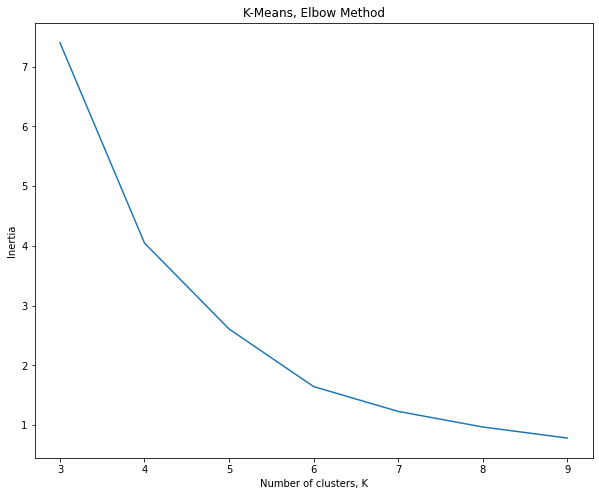

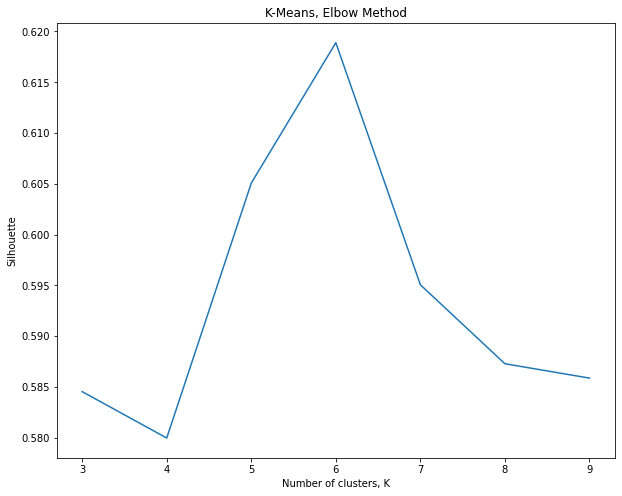

In [12]:
find_best_k_for_kmeans_clustering(data_vol, scaler=MinMaxScaler(), kmin=3, kmax=10)

## Train the Optimal KMeans Model

In [13]:
# train the optimal KMeans model and predict the cluster label

def predict_cluster_with_kmeans(dataframe, optimal_k, scaler, Random_State=42):
    from sklearn.cluster import KMeans;
    kmeans = KMeans(n_clusters=optimal_k, random_state=Random_State);
    dataframe_scaled = pd.DataFrame(data=scaler.fit_transform(dataframe[dataframe.columns]), columns=dataframe.columns);
    dataframe['cluster'] = kmeans.fit_predict(dataframe_scaled)
    return dataframe

In [14]:
data_vol = predict_cluster_with_kmeans(dataframe=data_vol, optimal_k=6, scaler=MinMaxScaler())
data_vol

,30_day_vol,cluster
30,0.006023,0
31,0.006005,0
32,0.005977,0
33,0.006283,0
34,0.006403,0
...,...,...
1274,0.005062,3
1275,0.005139,0
1276,0.005272,0
1277,0.005240,0


In [15]:
# view the descriptive stats on each cluster

def describe_each_cluster(dataframe_with_clusters, name_of_cluster_col): 
  for label in sorted(set(dataframe_with_clusters[name_of_cluster_col])):
    print('\n Cluster {}:'.format(label))
    display(dataframe_with_clusters.loc[dataframe_with_clusters[name_of_cluster_col]==label, :].describe().drop([name_of_cluster_col], axis=1).T)

In [16]:
describe_each_cluster(data_vol, 'cluster')


 Cluster 0:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,370.0,0.006058,0.000444,0.005139,0.005744,0.006095,0.006396,0.006918



 Cluster 1:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,106.0,0.013242,0.00077,0.011761,0.012747,0.01311,0.013835,0.014753



 Cluster 2:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,158.0,0.010185,0.000641,0.009013,0.00976,0.010253,0.01055,0.011595



 Cluster 3:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,343.0,0.004187,0.000623,0.002247,0.003897,0.00427,0.00467,0.005118



 Cluster 4:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,26.0,0.016734,0.000749,0.015196,0.016588,0.016952,0.017128,0.01788



 Cluster 5:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,246.0,0.007801,0.000478,0.006926,0.00746,0.007757,0.008117,0.008949


In [17]:
# create the bridging table to relabel clusters, used to create the transitional prob table later

data_vol['Cluster_Vol'] = data_vol.groupby(['cluster'])['30_day_vol'].transform('mean')
data_vol_relabel = data_vol[['cluster', 'Cluster_Vol']].drop_duplicates().sort_values(by=['Cluster_Vol'], ascending=True)
data_vol_relabel['new_cluster'] = range(1, len(data_vol_relabel)+1)
data_vol_relabel

,cluster,Cluster_Vol,new_cluster
214,3,0.004187,1
30,0,0.006058,2
56,5,0.007801,3
140,2,0.010185,4
528,1,0.013242,5
532,4,0.016734,6


In [18]:
# relabel the cluster in ascending order of mean volatility of each regime

data_vol = data_vol.merge(data_vol_relabel[['cluster','new_cluster']], on=['cluster', 'cluster'], how='left').drop(columns=['cluster'], axis=1).rename(columns={'new_cluster': 'cluster'})
data_vol

,30_day_vol,Cluster_Vol,cluster
0,0.006023,0.006058,2
1,0.006005,0.006058,2
2,0.005977,0.006058,2
3,0.006283,0.006058,2
4,0.006403,0.006058,2
...,...,...,...
1244,0.005062,0.004187,1
1245,0.005139,0.006058,2
1246,0.005272,0.006058,2
1247,0.005240,0.006058,2


In [19]:
# review the final clusters

describe_each_cluster(data_vol[['30_day_vol', 'cluster']], 'cluster')


 Cluster 1:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,343.0,0.004187,0.000623,0.002247,0.003897,0.00427,0.00467,0.005118



 Cluster 2:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,370.0,0.006058,0.000444,0.005139,0.005744,0.006095,0.006396,0.006918



 Cluster 3:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,246.0,0.007801,0.000478,0.006926,0.00746,0.007757,0.008117,0.008949



 Cluster 4:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,158.0,0.010185,0.000641,0.009013,0.00976,0.010253,0.01055,0.011595



 Cluster 5:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,106.0,0.013242,0.00077,0.011761,0.012747,0.01311,0.013835,0.014753



 Cluster 6:


,count,mean,std,min,25%,50%,75%,max
30_day_vol,26.0,0.016734,0.000749,0.015196,0.016588,0.016952,0.017128,0.01788


# Plot the Regime vs Actual 30_day_Vol

In [20]:
# define plot function

def multiseries_trend_linechart(dataframe, trend=None, is_trend_dataframe_index=True, series=[], series_labels=[], figwidth=20, figheight=10, figtitle=None, legend_location='upper right', trend_axis_label=None, series_label=None):
    plt.figure(figsize=(figwidth, figheight));
    for i in range(0, len(series)):
        if is_trend_dataframe_index:
            plt.plot(dataframe.index, dataframe[series[i]], label=series_labels[i]);
        else:
            plt.plot(dataframe[trend], dataframe[series[i]], label=series_labels[i]);
    plt.legend(loc=legend_location)
    plt.title(figtitle);
    plt.xlabel(trend_axis_label);
    plt.ylabel(series_label);

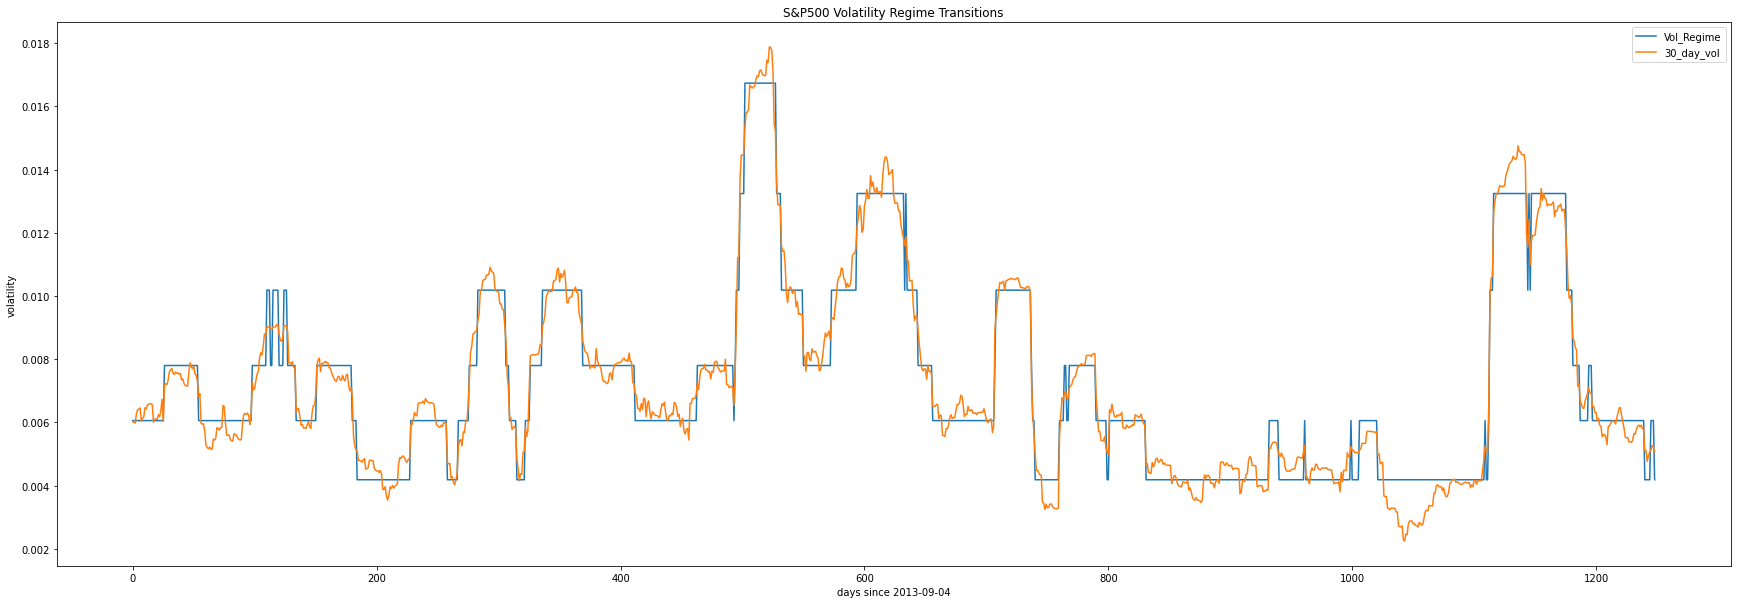

In [21]:
multiseries_trend_linechart(data_vol, series=['Cluster_Vol', '30_day_vol'], series_labels=['Vol_Regime', '30_day_vol'], figwidth=30, figheight=10, figtitle='S&P500 Volatility Regime Transitions', trend_axis_label='days since 2013-09-04', series_label='volatility')

# Calculate Transition Probability

In [22]:
# create cluster counts dataframe

data_vol_regime = data_vol.copy().drop(['Cluster_Vol'], axis=1)
data_vol_regime = data_vol_regime.groupby(['cluster']).agg([('Cluster_Vol', 'mean'), ('Count', 'size')]).droplevel(0, axis=1)
data_vol_regime

,Cluster_Vol,Count
cluster,,
1,0.004187,343
2,0.006058,370
3,0.007801,246
4,0.010185,158
5,0.013242,106
6,0.016734,26


In [23]:
# create the transitional probability table

data_vol_original = data_vol[['cluster']] #create a copy of dataframe for original volatility regime counts 
data_vol_shifted = data_vol.shift(periods=-1)[['cluster']].dropna().astype('int64') #create a copy of dataframe for counts of volatility regime in the next period   
vol_transition = data_vol_original.merge(data_vol_shifted, left_index=True, right_index=True, suffixes=('_from', '_to')).dropna()
vol_transition_table = pd.crosstab(vol_transition['cluster_from'], vol_transition['cluster_to'], normalize='index')
vol_transition_table

cluster_to,1,2,3,4,5,6
cluster_from,,,,,,
1,0.964912,0.035088,0.000000,0.000000,0.000000,0.000000
2,0.035135,0.932432,0.029730,0.002703,0.000000,0.000000
3,0.000000,0.048780,0.918699,0.032520,0.000000,0.000000
4,0.000000,0.000000,0.056962,0.905063,0.037975,0.000000
5,0.000000,0.000000,0.000000,0.056604,0.933962,0.009434
6,0.000000,0.000000,0.000000,0.000000,0.038462,0.961538
